In [ ]:
# Modificando VGG incrementado 3 capas itermedias (CONV => RELU) * 3 => POOL

In [26]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

def build(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = Sequential()
	inputShape = (height, width, depth)
	chanDim = -1
 
	# if we are using "channels first", update the input shape
	# and channels dimension
	if K.image_data_format() == "channels_first":
		inputShape = (depth, height, width)
		chanDim = 1
	# CONV => RELU => POOL
	model.add(Conv2D(32, (3, 3), padding="same",
		input_shape=inputShape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(3, 3)))
	model.add(Dropout(0.25))
	# (CONV => RELU) * 2 => POOL
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
    
# (CONV => RELU) * 3 => POOL layer set
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(512))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
 
	# softmax classifier
	model.add(Dense(classes))
	model.add(Activation("softmax"))
 
	# return the constructed network architecture
	return model 

In [1]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.models import model_from_json
from keras.layers.pooling import AveragePooling2D
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

IMAGE_DIMS = (64, 64, 3)
# initialize the data and labels
data = []
labels = []
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Convolutional Neural Network
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
path = '/home/jorgel/Documents/faceRec/dataset'
imagePaths = sorted(list(paths.list_images(path)))
print(len(imagePaths))
random.seed(42)
random.shuffle(imagePaths)

/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[INFO] loading images...
1610


In [2]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    face = face_cascade.detectMultiScale(image, 1.1, 7)
    x = face[0][0]
    y = face[0][1]
    w = face[0][2]
    h = face[0][3]
    #print(x,y,h,w)
    crop_img = image[y:y+h, x:x+w]
    img = cv2.resize(crop_img, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    img = img_to_array(img)    
    data.append(img)
 
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

data = np.array(data, dtype="float") / 255
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [3]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels,test_size=0.2,random_state=42)

In [4]:
print("Size {}".format(len(labels)))
print(labels.shape)
print(trainX.shape, testX.shape)
print(trainY.shape, testY.shape)

Size 1610
(1610, 7)
(1288, 64, 64, 3) (322, 64, 64, 3)
(1288, 7) (322, 7)


In [22]:
np.savetxt("trainX.txt",trainX.flatten())

In [23]:
np.savetxt("TestX.txt",testX.flatten())

In [24]:
np.savetxt("TrainY.txt",trainY.flatten())

In [25]:
np.savetxt("TestY.txt",testY.flatten())

In [27]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32


print("[INFO] compiling model...")
model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],depth=IMAGE_DIMS[2], classes=7)

[INFO] compiling model...


In [28]:
## Modelo modificado
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='VGG16_A.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 21, 21, 64)        0         
__________

In [29]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [30]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [31]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/50
40/40 [==============================] - 29s 730ms/step - loss: 2.9995 - acc: 0.1845 - val_loss: 3.3928 - val_acc: 0.2422
Epoch 2/50
40/40 [==============================] - 27s 675ms/step - loss: 2.1965 - acc: 0.3016 - val_loss: 2.7948 - val_acc: 0.3385
Epoch 3/50
40/40 [==============================] - 27s 673ms/step - loss: 1.9811 - acc: 0.3447 - val_loss: 3.7046 - val_acc: 0.2857
Epoch 4/50
40/40 [==============================] - 27s 674ms/step - loss: 1.6720 - acc: 0.4155 - val_loss: 2.4931 - val_acc: 0.3696
Epoch 5/50
40/40 [==============================] - 27s 674ms/step - loss: 1.5922 - acc: 0.4312 - val_loss: 3.4400 - val_acc: 0.2826
Epoch 6/50
40/40 [==============================] - 27s 684ms/step - loss: 1.4010 - acc: 0.4640 - val_loss: 2.0689 - val_acc: 0.4627
Epoch 7/50
40/40 [==============================] - 27s 674ms/step - loss: 1.4233 - acc: 0.4743 - val_loss: 1.5831 - val_acc: 0.5000
Epoch 8/50
40/40 [========================

/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
 

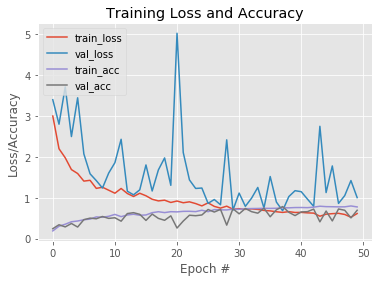

In [34]:
import matplotlib
matplotlib.use("Agg")
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("EmoTrain_1.png")
plt.show()

In [33]:
scores = model.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 72.28%
